**There are many good explanation for beginners, but I started from https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
and continued with https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist

I tried to modify images after image generator and to noise them, but it did not help.

So, pp. 0-5 are standart**

In [ ]:
#import os
#print(os.listdir("./"))

**0. Libraries**

In [ ]:
from copy import deepcopy
import os
import pandas as pd
import csv
import numpy as np
import keras
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import confusion_matrix
import itertools
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator


**1. Loading and prepare data**

In [ ]:
start_size = 28

data = pd.read_csv("../input/train.csv")
df = pd.DataFrame(data)

all_linear_data = df.as_matrix(columns=df.columns[1:])
all_labels = df.as_matrix(columns=df.columns[:1])
    
all_image_data = all_linear_data.reshape((df.shape[0], start_size, start_size, 1))
all_image_data = all_image_data / 255.0
all_labels = keras.utils.to_categorical(all_labels, 10)

validation_start = int((1 - 0.1) * all_image_data.shape[0])

train_data = all_image_data[0:validation_start]
train_labels = all_labels[0:validation_start]
validation_train_data = all_image_data[validation_start:]
validation_labels = all_labels[validation_start:]

test_data = pd.read_csv("../input/test.csv")
test_df = pd.DataFrame(test_data)

all_linear_test_image_data = test_df.as_matrix(columns=df.columns[1:])
all_test_image_data = all_linear_test_image_data.reshape((test_df.shape[0], start_size, start_size, 1))
all_test_image_data  = all_test_image_data  / 255.

**2. Model**

In [ ]:
def get_lr_metrics(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

def get_model():
    model = Sequential()

    model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(64,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    
    return model


model = get_model()
opimizer = Adam(1e-4)
model.compile(optimizer=opimizer, loss="categorical_crossentropy",
              metrics=["accuracy", get_lr_metrics(opimizer)])

**3. Running**

    First time I chose 100 epochs, but saw val_acc reachs the best value 0.99690 at 53th epochs and changed 100 in 60.

In [ ]:
datagen_args = dict(rotation_range=20,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    shear_range=0.1,
                    zoom_range=0.1)
datagen = ImageDataGenerator(**datagen_args)


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=5,
                                            verbose=1,
                                            factor=0.85,
                                            min_lr=1e-10)

weights_fname = 'mnist'
checkpoints = ModelCheckpoint(weights_fname + '-best.h5', monitor='val_acc', verbose=1,
                              save_best_only=True, save_weights_only=True, mode='max', period=1)

history = model.fit_generator(datagen.flow(train_data, train_labels, batch_size=64),
                              epochs=60, steps_per_epoch=train_data.shape[0]//64, # 0.9969 on 53th epoch
                              validation_data=(validation_train_data, validation_labels),
                              callbacks=[checkpoints, learning_rate_reduction],
                              verbose=0)

Epoch 00058: ReduceLROnPlateau reducing learning rate to 3.7714946120104284e-05.

Epoch 00059: val_acc did not improve from 0.99667

Epoch 00060: val_acc did not improve from 0.99667

**4. Curves**

In [ ]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(history.history['loss'], color='b', label='Training loss')
ax[0].plot(history.history['val_loss'], color='r', label='validation loss', axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation accuracy')
legend = ax[1].legend(loc='best', shadow=True)


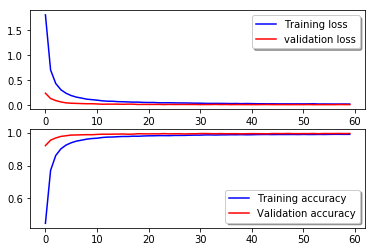

**5. Confusion matrix**

In [ ]:
def plot_confusion_matrix(cm,
                          classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
     
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
train_predicted_ohe = model.predict(all_image_data)
train_predicted_numbers = np.argmax(train_predicted_ohe, axis=1)
trained_true_numbers = np.argmax(all_labels, axis=1)

predict_ohe = model.predict(all_test_image_data)

confusion_mtx = confusion_matrix(trained_true_numbers, train_predicted_numbers)
plot_confusion_matrix(confusion_mtx, classes=range(10))

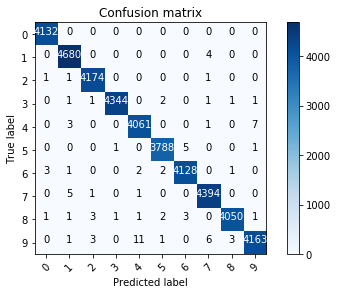

**6. Errors**

In [ ]:
def show_num_errors():
    all_errors = confusion_mtx.sum()
    for ind in range(10):
        all_errors = all_errors - confusion_mtx[ind, ind]

    print('------------------------------')
    print(f'all errors: {all_errors} from {all_image_data.shape[0]} ( {100.0 * all_errors / all_image_data.shape[0]} percent)')
    print('------------------------------')
    
show_num_errors()

**------------------------------

all errors: 86 from 42000 ( 0.20476190476190476 percent)

------------------------------**

**6.1. Show all problem images**

In [ ]:
def display_all_problem_images():
    # display errors for each cipher
    for cipher in range(10):
        number_errors = confusion_mtx[cipher, :].sum() - confusion_mtx[cipher, cipher]

        for index in range(10):
            num_errors = confusion_mtx[cipher, index]
            if (index == cipher) or (num_errors == 0):
                continue

            print(f"True label is {cipher}, but predicted is {index}")

            num_rows = 1 + num_errors // 10        
            plt.figure(figsize=(10 * 1, num_rows * 1))
            plt.axis('off')    

            current_error = 0
            current_index = 0
            while current_error < num_errors:
                if  (trained_true_numbers[current_index] == cipher) and (train_predicted_numbers[current_index] == index):
                    ax = plt.subplot(num_rows, 10, current_error + 1)
                    ax.xaxis.set_major_locator(ticker.NullLocator())
                    ax.xaxis.set_minor_locator(ticker.NullLocator())
                    ax.yaxis.set_major_locator(ticker.NullLocator())
                    ax.yaxis.set_minor_locator(ticker.NullLocator())                
                    plt.imshow(all_image_data[current_index].reshape(start_size, start_size), cmap='gray')
                    current_error = current_error + 1
                current_index = current_index + 1

            plt.show()
            
#display_all_problem_images()

**7. Fitting**

    I saved the best weights into h5 file. Now I am going to load them, and fit again. Data generator each time wil produce slightly different data, so I hope to find other slightly different local maximum for approximate function and to use those new weights for another prediction. I hope, new and old prediction would be different. Then I will repeat the same procedure a few times and each weights set will vote for each image. Then I will select the best digit for each image.

In [ ]:
for index in range(0, 10):
    
    print(f'index is {index} from 0-9')
    
    model = get_model()
    opimizer = Adam(1e-4)
    model.compile(optimizer=opimizer, loss="categorical_crossentropy",
              metrics=["accuracy", get_lr_metrics(opimizer)])    
    
    model.load_weights(weights_fname + '-best.h5')
    
    history = model.fit_generator(datagen.flow(train_data, train_labels, batch_size=64),
                                  epochs=55, steps_per_epoch=train_data.shape[0]//64,
                                  validation_data=(validation_train_data, validation_labels),
                                  callbacks=[checkpoints, learning_rate_reduction],
                                  initial_epoch=0,
                                  verbose=0)
    
    train_predicted_ohe_current = model.predict(all_image_data)
    train_predicted_ohe = train_predicted_ohe + train_predicted_ohe_current
    train_predicted_numbers = np.argmax(train_predicted_ohe, axis=1)

    confusion_mtx = confusion_matrix(trained_true_numbers, train_predicted_numbers)
    plot_confusion_matrix(confusion_mtx, classes=range(10))
    
    show_num_errors()
    
    predict_ohe_current = model.predict(all_test_image_data)
    predict_ohe = predict_ohe + predict_ohe_current

**8. Results**

    Finally, I have got val_acc = 0.99762 and 44 errors on the train dataset.
    I want to show all problem images from the train dataset.
    Then I run the code above one more time and have got val_acc = 0.99762 and 39 errors.
    Next time I got the same result.
    So, this is my final result.

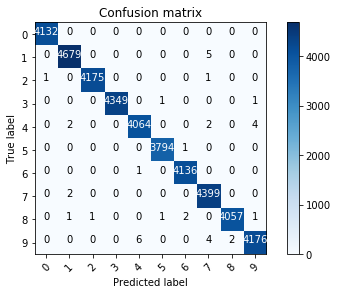

True label is 1, but predicted is 7
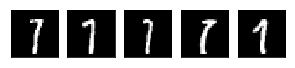

True label is 2, but predicted is 0
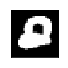

True label is 2, but predicted is 7
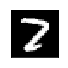

True label is 3, but predicted is 5
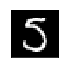

True label is 3, but predicted is 9
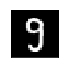

True label is 4, but predicted is 1
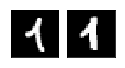

True label is 4, but predicted is 7
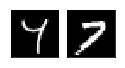

True label is 4, but predicted is 9
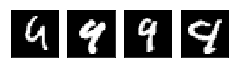

True label is 5, but predicted is 6
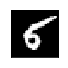

True label is 6, but predicted is 4
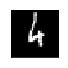

True label is 7, but predicted is 1
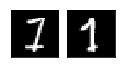

True label is 8, but predicted is 1
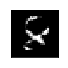

True label is 8, but predicted is 2
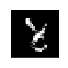

True label is 8, but predicted is 5
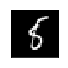

True label is 8, but predicted is 6
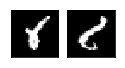

True label is 8, but predicted is 9
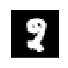

True label is 9, but predicted is 4
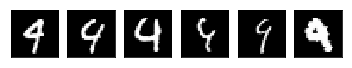

True label is 9, but predicted is 7
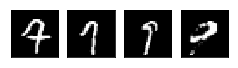

True label is 9, but predicted is 8
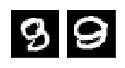

In [ ]:
display_all_problem_images()

You could see many problem images are really problematic. But from those 39 images I see 8 can be recognized right.

**9. Predicting**

In [ ]:
results = np.argmax(predict_ohe, axis=1)
results = pd.Series(results, name="Label")
submission = pd.concat([pd.Series(range(1, 28001), name="ImageId"), results], axis=1)

**9. Downloading**

In [ ]:
# import the modules we'll need
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "mnist_results1.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(submission)

    I do not know what exactly helped: many iterations or averaging. Anyway, I posted last results and has 0.997 accuracy (top 10%).